## Week 15 Medium - 三一投資管理公司

In [1]:
import tejapi 
import pandas as pd
import numpy as np
tejapi.ApiConfig.api_key = "YOUR KEY"
tejapi.ApiConfig.ignoretz = True
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from functools import reduce

### 投資策略說明
- 根據三一公司的研究，有三項結果：
    - 1980至1994年間S&P500指數中，以本益比最低的30%股票為投資組合(每季更新替換)，年平均報酬率為17.5%，而同期S&P500指數的報酬率為13.3%
    - 1980至1994年間，以股價帳面價值比最低的30%的股票為投資組合(每季更新替換)，年平均報酬率為18.1%，高出S&P500指數報酬率4.8%。
    - 以股利收益率最高的30%股票為投資組合，年平均報酬率達18.3%，高出S&P500指數報酬率5%。
    - 本次我們以台灣50成分股取代SP500

- 根據選股原則，投資程序如下：
    - 將各公司當天的的本益比由低到高進行排序，取最低的前30%公司
    - 將各公司當天的股價帳面價值比由低到高進行排序，取最低的前30%公司
    - 將各公司當天的股利收益率由高到低進行排序，取最高的前30%公司
    - 最後我們取這三個條件的聯集，也就是任一個標準符合即可，而之所以不取交集的原因，是因為這三者同時都要滿足，就是一間本益比偏低、PB比偏低但股利率卻偏高的公司，很有可能有長期經營成長的問題，且高股利率可能是在掩飾股價長期可能走低得市場預期。

In [2]:
stk_info = pd.read_csv('TW50.csv',engine='python')
stk_nums = stk_info['成份股'].apply(lambda x: str(x).split(' ')[0])

strategy_cols = ['公司代碼','財報年月','當季季底P/E', '當季季底P/B', '股利殖利率']

# 撈取財務資料
## 2008年到2020年
df_foundamental = pd.DataFrame()
q_df_stock = pd.DataFrame()
df_stock_Qrt = pd.DataFrame()

for stk in stk_nums:
    df_foundamental = df_foundamental.append(tejapi.get('TWN/AIM1A'
                        ,coid=stk
                        ,mdate={'gte':'2008-01-01', 'lte':'2020-12-31'}
                        ,paginate=True,chinese_column_name=True
                        ,opts={'pivot':True}
                        )).reset_index(drop=True)
    
    df_stock = tejapi.get('TWN/APRCM'
                    ,coid=stk
                    ,mdate={'gte':'2008-01-01', 'lte':'2020-12-31'}
                    ,paginate=True,chinese_column_name=True)
    
    q_df_stock = q_df_stock.append(df_stock.resample('Q', on='年月').last().reset_index(drop=True))


In [3]:
stk_info.head()

,年月日,成份股,指數因子,公眾流通係數,比重上限因子,股數,指數基值,前日調整收盤價,前日市值比重
0,2021/02/25,1101 台泥,2.3678,0.87,1,"5,810,254,882","2,134,842,990",42.55,0.7431
1,2021/02/25,1102 亞泥,1.0864,0.69,1,"3,361,447,198","2,134,842,990",43.00,0.3446
2,2021/02/25,1216 統一,2.2623,0.85,1,"5,682,015,421","2,134,842,990",69.10,1.1530
3,2021/02/25,1301 台塑,2.2960,0.77,1,"6,365,740,781","2,134,842,990",100.00,1.6934
4,2021/02/25,1303 南亞,2.6748,0.72,1,"7,930,821,589","2,134,842,990",73.80,1.4559


In [4]:
np.array(stk_nums.tolist())

array(['1101', '1102', '1216', '1301', '1303', '1326', '1402', '2002',
       '2105', '2207', '2303', '2308', '2317', '2327', '2330', '2357',
       '2379', '2382', '2395', '2408', '2412', '2454', '2474', '2633',
       '2801', '2880', '2881', '2882', '2883', '2884', '2885', '2886',
       '2887', '2890', '2891', '2892', '2912', '3008', '3034', '3045',
       '3711', '4904', '4938', '5871', '5876', '5880', '6415', '6505',
       '6669', '9910'], dtype='<U4')

In [5]:
df_indexcomp = tejapi.get('TWN/AIDXS', coid= 'TWN50', 
                  opts={'columns':['coid', 'mdate', 'key3']},
                  mdate={'gte':'2021/02/25', 'lte': '2021/02/25'}, paginate=True)

In [6]:
df_indexcomp.head()

,coid,mdate,key3
None,,,
0,TWN50,2021-02-25,1101 台泥
1,TWN50,2021-02-25,1102 亞泥
2,TWN50,2021-02-25,1216 統一
3,TWN50,2021-02-25,1301 台塑
4,TWN50,2021-02-25,1303 南亞


In [7]:
df_indexcomp['stk'] = [df_indexcomp.iloc[i,2].split(' ')[0] for i in range(df_indexcomp.shape[0])]
df_indexcomp['name'] = [df_indexcomp.iloc[i,2].split(' ')[1] for i in range(df_indexcomp.shape[0])]
ticks = df_indexcomp.stk.unique()

In [8]:
ticks

array(['1101', '1102', '1216', '1301', '1303', '1326', '1402', '2002',
       '2105', '2207', '2303', '2308', '2317', '2327', '2330', '2357',
       '2379', '2382', '2395', '2408', '2412', '2454', '2474', '2633',
       '2801', '2880', '2881', '2882', '2883', '2884', '2885', '2886',
       '2887', '2890', '2891', '2892', '2912', '3008', '3034', '3045',
       '3711', '4904', '4938', '5871', '5876', '5880', '6415', '6505',
       '6669', '9910'], dtype=object)

In [9]:
df_foundamental.rename(columns={'公司代碼':'coid','財報年月':'日期'},inplace=True)
df_foundamental = df_foundamental[['coid','日期','當季季底P/E', '當季季底P/B', '股利殖利率']]
df_foundamental

,coid,日期,當季季底P/E,當季季底P/B,股利殖利率
0,1101,2008-03-01,22.77,2.37,3.40
1,1101,2008-06-01,18.22,1.78,4.88
2,1101,2008-09-01,10.36,0.88,10.58
3,1101,2008-12-01,26.56,1.23,4.90
4,1101,2009-03-01,33.06,1.24,4.72
...,...,...,...,...,...
2474,9910,2019-12-01,14.56,8.62,3.08
2475,9910,2020-03-01,9.99,5.33,4.62
2476,9910,2020-06-01,14.14,7.87,3.60
2477,9910,2020-09-01,19.44,9.12,2.88


In [10]:
q_df_stock.rename(columns={'證券代碼':'coid','年月':'日期'},inplace=True)
q_df_stock = q_df_stock[['coid','日期','收盤價(元)_月']]
q_df_stock

,coid,日期,收盤價(元)_月
0,1101,2008-03-01,58.90
1,1101,2008-06-01,41.00
2,1101,2008-09-01,18.65
3,1101,2008-12-01,26.95
4,1101,2009-03-01,27.95
...,...,...,...
47,9910,2019-12-01,195.00
48,9910,2020-03-01,130.00
49,9910,2020-06-01,166.50
50,9910,2020-09-01,173.50


In [11]:
new_df = pd.merge(q_df_stock, df_foundamental, on = ['日期', 'coid'])
new_df.sort_values(by='日期').reset_index(drop=True)

,coid,日期,收盤價(元)_月,當季季底P/E,當季季底P/B,股利殖利率
0,1101,2008-03-01,58.90,22.77,2.37,3.40
1,2892,2008-03-01,31.85,15.53,1.78,5.71
2,2308,2008-03-01,89.80,12.41,3.21,6.24
3,2303,2008-03-01,18.70,51.47,1.10,4.20
4,2912,2008-03-01,104.00,23.19,5.54,3.08
...,...,...,...,...,...,...
2414,1301,2020-12-01,96.40,25.24,1.85,2.49
2415,2379,2020-12-01,390.50,21.53,6.77,3.59
2416,2801,2020-12-01,17.95,22.43,1.13,2.56
2417,2912,2020-12-01,266.50,20.09,7.69,3.38


In [12]:
new_df['日期'] = pd.to_datetime(new_df['日期'])
new_df['Month'] = new_df['日期'].apply(lambda x:datetime.strftime(x,'%Y%m'))

In [13]:
df_pe_quantile = new_df.groupby('Month')['當季季底P/E'].quantile(0.3).reset_index().rename(columns={'當季季底P/E':'PE月quantile'})
df_pb_quantile = new_df.groupby('Month')['當季季底P/B'].quantile(0.3).reset_index().rename(columns={'當季季底P/B':'PB月quantile'})
df_div_quantile = new_df.groupby('Month')['股利殖利率'].quantile(0.7).reset_index().rename(columns={'股利殖利率':'Div月quantile'})

In [14]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Month'],
                                            how='outer'), [new_df,df_pe_quantile,df_pb_quantile,df_div_quantile])

In [15]:
df_merged 

,coid,日期,收盤價(元)_月,當季季底P/E,當季季底P/B,股利殖利率,Month,PE月quantile,PB月quantile,Div月quantile
0,1101,2008-03-01,58.90,22.77,2.37,3.40,200803,12.515,1.683,5.541
1,1102,2008-03-01,54.30,13.86,1.93,5.52,200803,12.515,1.683,5.541
2,1216,2008-03-01,45.05,19.92,2.52,5.55,200803,12.515,1.683,5.541
3,1301,2008-03-01,91.90,12.56,2.14,7.29,200803,12.515,1.683,5.541
4,1303,2008-03-01,75.50,10.81,1.97,8.87,200803,12.515,1.683,5.541
...,...,...,...,...,...,...,...,...,...,...
2414,5880,2020-12-01,20.35,13.69,1.17,5.16,202012,9.863,1.184,5.230
2415,6415,2020-12-01,2410.00,71.91,12.43,0.44,202012,9.863,1.184,5.230
2416,6505,2020-12-01,99.80,107.47,3.09,0.59,202012,9.863,1.184,5.230
2417,6669,2020-12-01,704.00,11.78,5.02,4.55,202012,9.863,1.184,5.230


In [16]:
df_filter = df_merged[(df_merged['當季季底P/E'] < df_merged['PE月quantile'])|
                      (df_merged['當季季底P/B'] < df_merged['PB月quantile'])|
                      (df_merged['股利殖利率'] > df_merged['Div月quantile'])].reset_index(drop =True)

In [17]:
df_filter 

,coid,日期,收盤價(元)_月,當季季底P/E,當季季底P/B,股利殖利率,Month,PE月quantile,PB月quantile,Div月quantile
0,1216,2008-03-01,45.05,19.92,2.52,5.55,200803,12.515,1.683,5.541
1,1301,2008-03-01,91.90,12.56,2.14,7.29,200803,12.515,1.683,5.541
2,1303,2008-03-01,75.50,10.81,1.97,8.87,200803,12.515,1.683,5.541
3,1326,2008-03-01,78.80,10.91,1.68,8.88,200803,12.515,1.683,5.541
4,1402,2008-03-01,51.20,12.39,2.40,3.91,200803,12.515,1.683,5.541
...,...,...,...,...,...,...,...,...,...,...
1381,4904,2020-12-01,61.20,18.33,2.96,5.31,202012,9.863,1.184,5.230
1382,4938,2020-12-01,67.30,6.71,1.10,6.69,202012,9.863,1.184,5.230
1383,5871,2020-12-01,168.00,9.41,2.43,3.27,202012,9.863,1.184,5.230
1384,5876,2020-12-01,41.10,8.55,1.19,4.14,202012,9.863,1.184,5.230


In [18]:
df_filter.sort_values(by = 'coid').reset_index(drop = True)

,coid,日期,收盤價(元)_月,當季季底P/E,當季季底P/B,股利殖利率,Month,PE月quantile,PB月quantile,Div月quantile
0,1101,2010-03-01,29.95,8.23,1.22,6.01,201003,11.810,1.299,5.724
1,1101,2011-06-01,42.80,9.87,1.63,4.67,201106,12.038,1.555,5.470
2,1101,2013-09-01,42.80,9.71,1.48,4.44,201309,10.697,1.290,4.556
3,1101,2011-09-01,32.90,7.67,1.30,6.08,201109,10.556,1.259,6.179
4,1101,2015-03-01,44.10,8.53,1.38,5.65,201503,10.078,1.310,5.385
...,...,...,...,...,...,...,...,...,...,...
1381,9910,2009-03-01,18.10,5.45,1.10,6.63,200903,11.798,1.112,5.627
1382,9910,2008-12-01,15.40,5.97,1.01,7.79,200812,10.170,1.010,5.694
1383,9910,2013-06-01,50.40,8.64,3.11,5.16,201306,10.384,1.150,4.885
1384,9910,2011-06-01,27.45,11.69,1.91,6.56,201106,12.038,1.555,5.470


In [19]:
import datetime
return_=pd.DataFrame()
dates = df_filter['日期'].astype(str).apply(lambda x: x.split(' ')[0]).unique()

for date in dates:
    
    # 設定日期
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = 1
    date1 = str(year)+'-'+str(month)+'-'+str(day)
    ret = [date1]
    pf = df_filter[df_filter['日期']==date].reset_index(drop=True)
    print(date1)
    
    ## 將買進日期設在當月1日 ##
    buy_date = datetime.datetime(year,month,day) + datetime.timedelta(90)
    sell_date = buy_date + datetime.timedelta(90) 
    pf_H = pf['coid'].to_list()
    print('getting data')
    data = tejapi.get('TWN/APRCD2',coid  = pf_H, paginate = True, mdate={'gte':buy_date,'lte':sell_date},chinese_column_name=True)
    q1_ret = data.groupby(by = '證券代碼').last()['季報酬率 %'].values
    
    # 計算報酬率 #
    print('calculating return')
    w = 1/len(pf_H) # 等權重 
    q1_wret = (w*q1_ret).tolist() # 加權平均報酬
    ret.append(round(sum(q1_wret),2))
    
    ## 撈取台灣 50指數的年報酬率，日期設定為 buy_date(含)至 sell_date(含) ##
    tw0050 = tejapi.get('TWN/APRCD2',coid ='TRI50' ,paginate = True,mdate={'gte':buy_date,'lte':sell_date},chinese_column_name=True)
    bm_return = tw0050.groupby(by = '證券代碼').last()['季報酬率 %'].values
    if bm_return.size!=0:
        ret.append(round(bm_return.tolist()[0],2))
    else:
        ret.append(None)
    rets = np.reshape(np.array(ret),(1,3)).tolist()
    retss = pd.DataFrame(data=rets,columns=['Date','port_return','twn50_return'])
    return_ = return_.append(retss).reset_index(drop=True)
    print(return_)

2008-3-1
getting data
calculating return
       Date port_return twn50_return
0  2008-3-1      -15.85       -12.71
2008-6-1
getting data
calculating return
       Date port_return twn50_return
0  2008-3-1      -15.85       -12.71
1  2008-6-1      -32.01       -36.52
2008-9-1
getting data
calculating return
       Date port_return twn50_return
0  2008-3-1      -15.85       -12.71
1  2008-6-1      -32.01       -36.52
2  2008-9-1        0.99         2.88
2008-12-1
getting data
calculating return
        Date port_return twn50_return
0   2008-3-1      -15.85       -12.71
1   2008-6-1      -32.01       -36.52
2   2008-9-1        0.99         2.88
3  2008-12-1       50.84        44.14
2009-3-1
getting data
calculating return
        Date port_return twn50_return
0   2008-3-1      -15.85       -12.71
1   2008-6-1      -32.01       -36.52
2   2008-9-1        0.99         2.88
3  2008-12-1       50.84        44.14
4   2009-3-1         4.9         2.92
2009-6-1
getting data
calculating return
  

In [20]:
return_

,Date,port_return,twn50_return
0,2008-3-1,-15.85,-12.71
1,2008-6-1,-32.01,-36.52
2,2008-9-1,0.99,2.88
3,2008-12-1,50.84,44.14
4,2009-3-1,4.9,2.92
5,2009-6-1,12.68,11.31
6,2009-9-1,-5.69,-4.37
7,2009-12-1,-1.59,-3.34
8,2010-3-1,15.33,8.95
9,2010-6-1,8.18,9.97


In [21]:
cum_ret = ((return_[['port_return', 'twn50_return']].astype(float)*0.01)+1).cumprod()
cum_ret['Date'] = return_['Date']  
cum_ret = cum_ret[:len(cum_ret)-1]
cum_ret = cum_ret[['Date','port_return','twn50_return']]

quarter_ret = return_[['port_return', 'twn50_return']].astype(float)
quarter_ret['Date'] = return_['Date']  
quarter_ret = quarter_ret[:len(quarter_ret)-1]
quarter_ret = quarter_ret[['Date','port_return','twn50_return']]

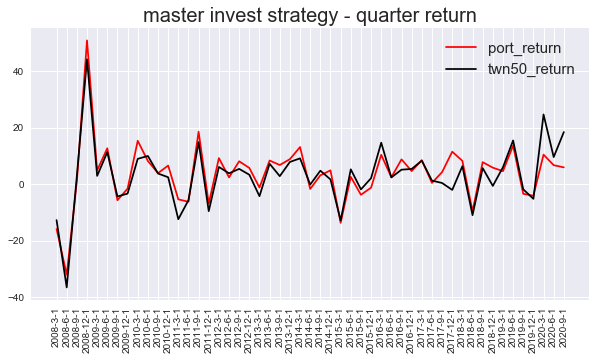

In [22]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('master invest strategy - quarter return',fontsize = 20)
date = quarter_ret['Date']
plt.plot(date,quarter_ret.port_return,color ='red',label='port_return')
plt.plot(date,quarter_ret.twn50_return,color = 'black',label='twn50_return')
plt.legend(fontsize = 15)

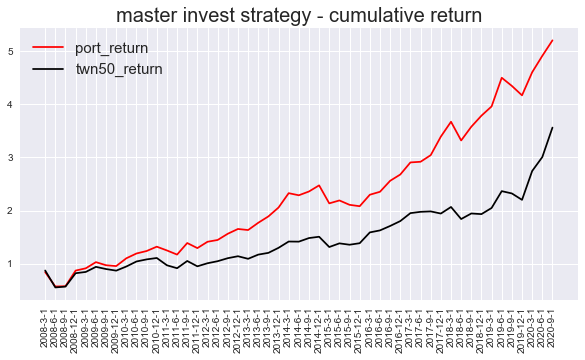

In [23]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('master invest strategy - cumulative return',fontsize = 20)
date = cum_ret['Date']
plt.plot(date,cum_ret.port_return,color ='red',label='port_return')
plt.plot(date,cum_ret.twn50_return,color = 'black',label='twn50_return')
plt.legend(fontsize = 15)

In [24]:
Ratio = pd.DataFrame()
for col in cum_ret.columns[1:]:
    
    ##年化報酬率
    cagr = (cum_ret[col].values[-1]) ** (4/len(cum_ret)) -1
    
    ##年化標準差
    std = return_[col][:len(return_)-1].astype(float).std()
    
    ##Sharpe Ratio(假設無風險利率為1%)
    sharpe_ratio = (cagr-0.01)/(std*0.01)
    
    ##最大回撤
    roll_max = cum_ret[col].cummax()
    monthly_dd =cum_ret[col]/roll_max - 1.0
    max_dd = monthly_dd.cummin()
    
    ##表格
    ratio = np.reshape(np.round(np.array([100*cagr, std, sharpe_ratio, 100*max_dd.values[-1]]),2),(1,4))
    Ratio = Ratio.append(pd.DataFrame(index=[col], 
      columns=['年化報酬率(%)', '年化標準差(%)', '夏普比率', '期間最大回撤(%)'], 
      data = ratio))
Ratio.T

,port_return,twn50_return
年化報酬率(%),13.81,10.47
年化標準差(%),11.01,11.17
夏普比率,1.16,0.85
期間最大回撤(%),-32.01,-36.52


In [25]:
pf = df_filter[df_filter['日期']== '2020-12-01'].reset_index(drop=True)

# 回台灣 50成分股查詢 P1組合的名稱
stk_info['stk_num'] = stk_info['成份股'].apply(lambda x: str(x).split(' ')[0])
stk_info['stk_cname'] = stk_info['成份股'].apply(lambda x: str(x).split(' ')[1])
stk_info['成份股'][stk_info['stk_num'].isin(pf['coid'].tolist())].to_list()

['1101 台泥',
 '1102 亞泥',
 '1402 遠東新',
 '2317 鴻海',
 '2357 華碩',
 '2382 廣達',
 '2474 可成',
 '2801 彰銀',
 '2881 富邦金',
 '2882 國泰金',
 '2883 開發金',
 '2885 元大金',
 '2886 兆豐金',
 '2887 台新金',
 '2890 永豐金',
 '2891 中信金',
 '4904 遠傳',
 '4938 和碩',
 '5871 中租-KY',
 '5876 上海商銀',
 '5880 合庫金']